Подключаем необходимые модули для первичного анализа данных, работы с текстом и обучения линейных моделей:

In [1]:
import pandas as pd 
import numpy as np

import gc
import time
import warnings

import scipy
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#визуализация
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from PIL import Image
!pip install matplotlib_venn
import matplotlib_venn as venn
!pip install wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [2]:
#нлп-библиотеки
import string
import re    #регулярные выражения
import nltk
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords               #стоп-слова
!pip install spacy
import spacy
from nltk import pos_tag
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer #лемматизация 
from nltk.tokenize import word_tokenize         #токенизация
from nltk.tokenize import TweetTokenizer   

#извлечение фичей
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#настройки
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english")) #множество стоп-слов

#выключаем всякие предупреждения 
warnings.filterwarnings("ignore")

#пааметры для предобработки
lem = WordNetLemmatizer()      
tokenizer=TweetTokenizer()

%matplotlib inline

## Первичный анализ данных

In [4]:
train=pd.read_csv("train.csv")
test=pd.read_csv("updated_test.csv")

In [5]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train[-5:]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [9]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 63978
perc   : 71    : 29


Обучающая/тестовая выборки - 70%/30%. Много пустых строк, а значит и неотнесённых ни к какому классу токсичности комментариев, посчитаем, сколько их.

In [10]:
x=train.iloc[:,2:].sum(axis=0)
x
#train.iloc[[6],1:]

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [11]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=1-train[class_names].max(axis=1)
print("Всего комментариев = ",len(train))
print("Всего чистых комментариев = ",train['clean'].sum())
print("Общее число тегов(единичек) по всем классам =",x.sum())

Всего комментариев =  159571
Всего чистых комментариев =  143346
Общее число тегов(единичек) по всем классам = 35098


Видим, что подавляющее число комментариев - есть не отнесённые ни в какой класс - значит, возможно они несут в себе нейтральный или положительный эмоциональный окрас. Также становится понятно, что имеем дело действительно задачей многоклассовой классификации с пересекающимися классами, так как 159571 < 143346 + 35098. Посмотрим на распределение комментариев по классам:

In [12]:
#заполним пустые строки, если они есть
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

In [13]:
train[train.comment_text == 'unknown']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean


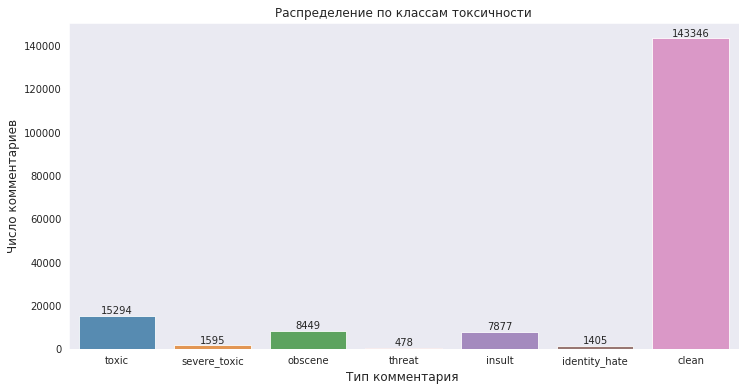

In [14]:
x=train.iloc[:,2:].sum()
#гистограмма частот попадания в класс
plt.figure(figsize=(12,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Распределение по классам токсичности")
plt.ylabel('Число комментариев', fontsize=12)
plt.xlabel('Тип комментария ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

fig1 = plt.gcf()
plt.show()
fig1.savefig('Distribution_classes.png', bbox_inches='tight')

Действительно, классы несбалансированы, могут быть проблемы при разбиении трэйна на обучающую и валидационную выборки. Теперь посмотрим, как много комментов, относяшихся к нескольким классам одновременно.

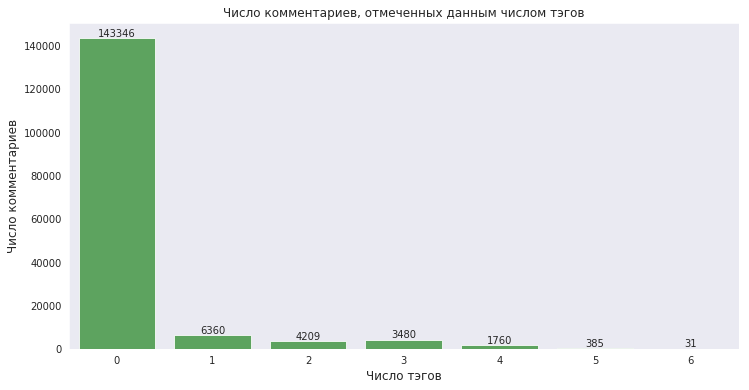

In [15]:
x=rowsums.value_counts()

#гистограмма
plt.figure(figsize=(12,6))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Число комментариев, отмеченных данным числом тэгов")
plt.ylabel('Число комментариев', fontsize=12)
plt.xlabel('Число тэгов', fontsize=12)

#добавляем лейблы
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

fig1 = plt.gcf()
plt.show()
fig1.savefig('Distribution_amount_of_tags.png', bbox_inches='tight')

In [16]:
train[rowsums == 6][:5]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,1,1,1,1,1,0
1312,039296aa294ee10b,"SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!",1,1,1,1,1,1,0
7299,1368c10281978876,"You're a stupid cunt \n\nFuck you dumb arse, y...",1,1,1,1,1,1,0
13648,2405c66d017f139e,Bitch \n\nYou are a little bitch. I fuckin spe...,1,1,1,1,1,1,0
13964,24d2b50726b67167,I am going to murder ZimZalaBim ST47 for being...,1,1,1,1,1,1,0


Возможно, есть какие-то корреляции между классами, построим корреляционную матрицу.

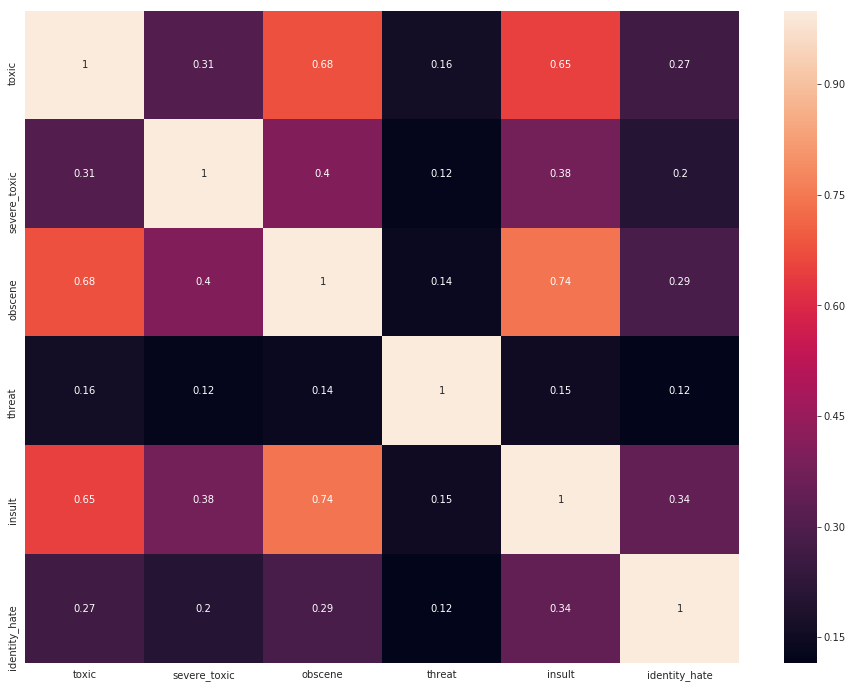

In [17]:
temp_df=train.iloc[:,2 :-1]

corr=temp_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

fig1 = plt.gcf()
plt.show()
fig1.savefig('Корреляционная матрица.png', bbox_inches='tight')

Больших значений в матрице нет, паттерн есть разве что между "токсичным" и "непристойным" классами. Они часто встречаются вместе.

Примеры комментариев каждого типа:

In [18]:
print('Токсичный комментарий:')
print(train[(train.severe_toxic == 1) & (train.toxic == 1)].iloc[3,1])

Токсичный комментарий:
Hi 

Im a fucking bitch.

50.180.208.181


In [19]:
print('Высокотоксичный комментарий:')
train[(train.severe_toxic == 1) & (train.toxic == 1)].iloc[4,1] 

Высокотоксичный комментарий:


'What a motherfucking piece of crap those fuckheads for blocking us!'

In [20]:
print('Непристойный комментарий:')
train[(train.index == 176) & (train.obscene == 1) & (train.toxic == 1)].iloc[0,1]

Непристойный комментарий:


"I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms"

In [21]:
print('Комментарий типа "угроза":')
train[ (train.index == 1312) & (train.threat == 1) & (train.toxic == 1)].iloc[0,1]

Комментарий типа "угроза":


'SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!'

In [22]:
print('Комментарий типа "оскорбление:')
train[(train.index == 238) & (train.insult == 1) & (train.toxic == 1)].iloc[0,1]

Комментарий типа "оскорбление:


'u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie'

In [23]:
print('Расово-направленный комментарий:')
train[(train.identity_hate == 1) & (train.toxic == 1)].iloc[1,1]

Расово-направленный комментарий:


'A pair of jew-hating weiner nazi schmucks.'

## Извлечение первичных признаков:
-число предложений

-число слов

-число уникальных слов

-доля уникальных слов от общего числа слов

-число cимволов

-число знаков пунктуации

-доля знаков пунктуации

-число слов с большой буквы/слов, написанных большими буквами

-число стоп-слов

-средняя длина слова

-число восклицательных/вопросительных знаков

-число слов из множества {"you", "You", "YOU"}

### Важно извлечь первичные признаки, т.к. они могут нести в себе много информации о текстах, которая в дальнейшем будет потеряна после очистки данных, например, большое количество знаков пунктуации - смайликов, восклицательных или вопроситеьлных знаков говорит о наличии в комментарии какого-то сентимента, что перд нами, скорее всего, не нейтральный комментарий, а несущий в себе некий "сентимент". 

In [24]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)
df.tail()

,id,comment_text
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ..."
223545,fff9d70fe0722906,==Lucky bastard== \r\n http://wikimediafoundat...
223546,fffa8a11c4378854,==shame on you all!!!== \r\n\r\n You want to s...
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...
223548,fffb5451268fb5ba,""" \r\n\r\n == Unicorn lair discovery == \r\n\r..."


In [25]:
#Извлекаем фичи пользуясь лямбда-функциями и библиотекой re для регулярных выражений

#Число предложений в каждом комменте
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Число слов в каждом комменте
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Число уникальных слов
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Число символов
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#Число знаков пунктуации
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#Число слов, написанных БОЛЬШИМИ БУКВАМИ
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#Число слов, начинающихся с большой буквы
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Число стоп-слов
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Число восклицательных знаков
df['num_exclamation_marks'] = df['comment_text'].apply(lambda x: x.count('!'))
#Число вопросительных знаков
df['num_question_marks'] = df['comment_text'].apply(lambda x: x.count('?'))
#Число слов "YOU", "You", "you" 
df['you_count'] = df['comment_text'].apply(lambda x: np.sum(x.count(w) for w in ('you', 'You', 'YOU')))
#Средняя длина слова
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#Доля уникаьных слов от общего числа слов в комменте
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#Число знаков пунктуации на общее число слов в комменте
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [26]:
a = np.sum((train[train.index == 1017].iloc[0,1].count(s) for s in ["YOU", "You", "you"]))
a

6

In [27]:
train[train.index == 1017].iloc[0,1]

"WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER."

In [28]:
df.iloc[[1017],:]

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,num_exclamation_marks,num_question_marks,you_count,mean_word_len,word_unique_percent,punct_percent
1017,02c6e41e4b317ac3,WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...,1,28,23,150,6,28,0,13,0,0,6,4.392857,82.142857,21.428571


Далее разделяем фичи для трэйна и теста, затем добавляем лейблы классов

In [29]:
#датасет фичей разделяем по исходной длине обучающей и тестовой выборок
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]

#лэйблы классов прицепляем к фичам
train_tags=train.iloc[:,2:]

#итоговый датасет с первичными признаками для обучающей выборки: 
train_feats=pd.concat([train_feats,train_tags],axis=1)

In [30]:
train_feats[:3]

,id,comment_text,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,...,mean_word_len,word_unique_percent,punct_percent,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,264,10,2,11,18,...,5.162791,95.348837,23.255814,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,112,12,1,3,2,...,5.588235,100.000000,70.588235,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,233,6,0,2,20,...,4.571429,92.857143,14.285714,0,0,0,0,0,0,1


In [31]:
test_feats = test_feats.set_index(np.arange(len(test_feats)))

### Далее проводим очистку текстов. Она состоит из токенизации и нормализации. В свою очередь для нармализации существует два подхода - лемматизация и стемминг. Всё это необходимо для извлечения TF-IDF для слов, словосочетаний и букв.

In [32]:
corpus=merge.comment_text #работать будем со столбцом комментариев как из трейна, так и из теста

In [33]:
corpus.tail()

63973    :Jerome, I see you never got around to this…! ...
63974    ==Lucky bastard== \r\n http://wikimediafoundat...
63975    ==shame on you all!!!== \r\n\r\n You want to s...
63976    MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...
63977    " \r\n\r\n == Unicorn lair discovery == \r\n\r...
Name: comment_text, dtype: object

Нам понадобится словарь для разделения слов с апострофами на два слова, его можно найти по ссылке:
https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view 
из блог-поста https://www.analyticsvidhya.com/blog/2015/06/quick-guide-text-data-cleaning-python/ 

In [34]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [35]:
#создаём функцию для очистки отдельного комментария, возвращающую "чистый" массив слов комментария
def clean(comment):
    #Приводим всё к нижнему регистру
    comment=comment.lower()
    
    #Удаляем переносы на новую строку
    comment=re.sub("\\n","",comment)
    
    #Удаляем ip-шники
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #Удаляем никнеймы
    comment=re.sub("\[\[.*\]","",comment)
    
    #делим комменты на слова, используя TweetTokenizer, который не разделяет слово с апострофом на два, мы это сделаем "красивее" далее
    words=tokenizer.tokenize(comment) 
    
    # заменяем слова c апострофами на два слова, пользуясь словарём APPO. Например, you're --> you are
    words=[APPO[word] if word in APPO else word for word in words]
    
    #для лемматизации используем функцию WordNetLemmatizer() из модуля nltk
    words=[lem.lemmatize(word, "v") for word in words]
    
    #фильтруем на наличие стоп-слов
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    
    #удаляем все символы, не являющиеся буквами или цифрами
    #clean_sent=re.sub("\W+"," ",clean_sent)
    
    #clean_sent=re.sub("  "," ",clean_sent)
    
    #стемминг можно было бы сделеать, но он ухудшил качесво линейные модели, поэтому приводим лишь возможный для него код:
    '''
        clean_sent = clean_sent.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in clean_sent]
        clean_sent = " ".join(stemmed_words)                          
    '''
    
    return(clean_sent)

In [36]:
corpus.iloc[1312]

'SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!'

In [37]:
clean(corpus.iloc[1312])

'shut , fat poop , kick ass ! ! !'

In [38]:
corpus.iloc[12235]

'"\n\n NOTE If you read above, and follow the links, any reader can see that I cited correctly the links I added on this subject. Vidkun has added anotations to make them read as the oposite, but these links show the ""official"" line taken by UGLE. I will not be trapped by any User into so-called 3RR, so he can peddle his POV. Strangly, ALL other ""MASONS"" are quiet, leaving ‘‘me’’ to defend that factual truth on my own. ""Thanks"" Brethren. Sitting any blocking out if given...  "'

In [39]:
clean(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [40]:
clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("Время, затраченное на очистку данных",end_time-start_time)

Время, затраченное на очистку данных 159.47062373161316


### Извлекаем TF-IDF для униграмм, биграмм, и буквенным n-грамм (от 1 до 4 символов). При этом извлекаем их на общем корпусе текстов, иначе лог.регрессия не сможет обучиться на незнакомых словах из теста, которых нет в обучающей выборке.

In [41]:
#Считаем TF-IDF для униграмм: 
# настройки брал отсюда - https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#параметры означают:
# min_df=10 игнорируем токены, которые появились в комментариях менее 10 раз
# max_features=10000 лимит на количество фичей
# analyzer='word' - делаем фичи для униграмм и биграмм, т.е. работаем со словами
# ngram_range=(1,1)  - униграммы 
# use_idf=1,smooth_idf=1 - считаем IDF
# sublinear_tf=1   - используем нормировку для увеличения значений TF, заменяя исходные значения TF на 1 + log(TF)

start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=10,  max_features=10000, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [42]:
train_unigrams

<159571x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3375436 stored elements in Compressed Sparse Row format>

In [43]:
#Считаем TF-IDF для биграмм: 
tfv = TfidfVectorizer(min_df=10,  max_features=30000, 
            strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_bigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_bigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [44]:
train_bigrams

<159571x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 1216984 stored elements in Compressed Sparse Row format>

In [45]:
#Считаем TF-IDF для символьным n-грамм от одного до четырёх символов:
#Настройки практически те же

tfv = TfidfVectorizer(min_df=10,  max_features=30000, 
            strip_accents='unicode', analyzer='char', token_pattern=r'\w{1,}',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_charngrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_charngrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [46]:
train_charngrams

<159571x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 78636594 stored elements in Compressed Sparse Row format>

In [47]:
start_feature_names = ['count_sent', 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations', 
                       'count_words_upper', "count_words_title", 'count_stopwords', 'num_exclamation_marks', 
                       'num_question_marks', 'you_count', "mean_word_len", "word_unique_percent", 'punct_percent']

start_features_train = train_feats[start_feature_names]
start_features_test = test_feats[start_feature_names]

In [48]:
train_features = hstack([start_features_train, train_unigrams, train_bigrams, train_charngrams]).tocsr()
test_features = hstack([start_features_test, test_unigrams, test_bigrams, test_charngrams]).tocsr()

In [49]:
test_features

<63978x70014 sparse matrix of type '<class 'numpy.float64'>'
	with 32639567 stored elements in Compressed Sparse Row format>

In [50]:
train_features

<159571x70014 sparse matrix of type '<class 'numpy.float64'>'
	with 85050203 stored elements in Compressed Sparse Row format>

# Обучение лог. регрессии и наивного байесовского классификатора

## Кросс-валидация

In [53]:
scores = []
for class_name in class_names:
    train_target = train[class_name]
    classifier = LogisticRegression(C = 1.0, solver='sag') # sag - оптимизация методом стохастического усреднённого градиентного спуска

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV-score для класса {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)

print('Средний CV-score - {}'.format(np.mean(scores)))


CV-score для класса toxic is 0.6192377682728468
CV-score для класса severe_toxic is 0.6938925939847689
CV-score для класса obscene is 0.6241914825025877
CV-score для класса threat is 0.6559110305107329
CV-score для класса insult is 0.6329579689194852
CV-score для класса identity_hate is 0.6342925983471902
Средний CV-score - 0.643413907089602


In [51]:
scores = []
for class_name in class_names:
    train_target = train[class_name]
    classifier = MultinomialNB(alpha=1) 

    cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV-score для класса {} is {}'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)

print('Средний CV-score - {}'.format(np.mean(scores)))


CV-score для класса toxic is 0.7218544266245307
CV-score для класса severe_toxic is 0.8181973802291153
CV-score для класса obscene is 0.7493740340214842
CV-score для класса threat is 0.6846347826369268
CV-score для класса insult is 0.7386671365883352
CV-score для класса identity_hate is 0.7363277506522178
Средний CV-score - 0.7415092517921016


## Предикт

In [55]:
scores = []
for class_name in class_names:
    clf = LogisticRegression(C=1.0)
    clf.fit(train_features, train[class_name])
    predictions = clf.predict_proba(test_features)[:, 1]
    score=roc_auc_score(test[class_name], predictions)
    scores.append(score)
    print ("ROC-AUC: %0.5f " % roc_auc_score(test[class_name], predictions))

print('Средний ROC-AUC score - {}'.format(np.mean(scores)))    

ROC-AUC: 0.77674 
ROC-AUC: 0.69998 
ROC-AUC: 0.76380 
ROC-AUC: 0.87608 
ROC-AUC: 0.76581 
ROC-AUC: 0.82309 
Средний ROC-AUC score - 0.7842498540717515


In [52]:
scores = []
for class_name in class_names:
    clf = MultinomialNB(alpha=1.0)
    clf.fit(train_features, train[class_name])
    predictions = clf.predict_proba(test_features)[:, 1]
    score=roc_auc_score(test[class_name].values, predictions)
    scores.append(score)
    print ("ROC-AUC: %0.5f " % roc_auc_score(test[class_name].values, predictions))

print('Средний ROC-AUC score - {}'.format(np.mean(scores)))    

ROC-AUC: 0.73724 
ROC-AUC: 0.73102 
ROC-AUC: 0.75014 
ROC-AUC: 0.73077 
ROC-AUC: 0.73902 
ROC-AUC: 0.77644 
Средний ROC-AUC score - 0.744105514449847
